In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import BallTree
from joblib import Parallel, delayed
import math
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    max_error,
    median_absolute_error
)
import os
from tqdm import tqdm

In [2]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1):
    """Enhanced spatial features while maintaining existing structure"""
    city_center_lat, city_center_lon = 48.8566, 2.3522
    
    # Keep existing spatial features
    spatial_data = {
        'distance_to_center': [],
        'north_south': [],
        'knn_price_mean': [],
        'knn_price_std': [],
        'price_diff_from_neighbors': []
    }
    
    # Add new spatial features
    spatial_data.update({
        'knn_price_median': [],  # Add median as more robust metric
        'knn_price_range': [],   # Add price range in neighborhood
        'distance_weighted_price': []  # Add distance-weighted price
    })
    
    # Calculate basic distance features (keeping existing logic)
    spatial_data['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    ).values
    
    spatial_data['north_south'] = (df['latitude'] - city_center_lat).values
    
    # Enhanced BallTree processing
    all_coords = np.radians(df[['latitude', 'longitude']].values)
    tree = BallTree(all_coords, metric='haversine')
    all_prices = df['price'].values
    
    def enhanced_process_chunk(chunk_data, tree, k_neighbors, all_prices):
        """Enhanced chunk processing with additional metrics"""
        coords = np.radians(chunk_data[['latitude', 'longitude']].values)
        distances, indices = tree.query(coords, k=k_neighbors + 1)
        
        # Convert distances to weights (inverse distance weighting)
        weights = 1 / (distances[:, 1:] + 1e-6)  # Add small epsilon to avoid division by zero
        weights = weights / weights.sum(axis=1, keepdims=True)
        
        neighbor_prices = np.take(all_prices, indices[:, 1:])
        
        return {
            'knn_price_mean': np.nanmean(neighbor_prices, axis=1),
            'knn_price_std': np.nanstd(neighbor_prices, axis=1),
            'knn_price_median': np.nanmedian(neighbor_prices, axis=1),
            'knn_price_range': np.ptp(neighbor_prices, axis=1),
            'price_diff_from_neighbors': chunk_data['price'].values - np.nanmean(neighbor_prices, axis=1),
            'distance_weighted_price': np.sum(weights * neighbor_prices, axis=1)
        }
    
    # Split and process chunks (keeping existing logic)
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(enhanced_process_chunk)(
            chunk, 
            tree, 
            k_neighbors,
            all_prices
        ) for chunk in chunks
    )
    
    # Combine results with new features
    for key in spatial_data.keys():
        if key not in ['distance_to_center', 'north_south']:
            spatial_data[key] = np.concatenate([r[key] for r in results])
    
    spatial_features = pd.DataFrame(spatial_data, index=df.index)
    
    # Enhanced feature standardization
    features_to_standardize = list(spatial_data.keys())
    
    for col in features_to_standardize:
        mean_val = spatial_features[col].mean()
        std_val = spatial_features[col].std()
        # Avoid division by zero
        if std_val > 0:
            spatial_features[col] = (spatial_features[col] - mean_val) / std_val
    
    return spatial_features

def evaluate_day_by_day_performance(daily_results):
    """Evaluate performance metrics for daily predictions"""
    # Combine all daily predictions into a single dataframe
    all_results = pd.concat(daily_results)
    
    # Calculate overall metrics
    y_true = all_results['actual']
    y_pred = all_results['predicted']
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'explained_variance': explained_variance_score(y_true, y_pred),
        'max_error': max_error(y_true, y_pred),
        'median_absolute_error': median_absolute_error(y_true, y_pred)
    }
    
    # Calculate daily metrics
    daily_metrics = []
    for day_df in daily_results:
        day = day_df['date'].iloc[0].strftime('%Y-%m-%d')
        y_true_day = day_df['actual']
        y_pred_day = day_df['predicted']
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / y_true_day)) * 100,
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    return {
        'overall_metrics': metrics,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results
    }

def plot_day_by_day_results(evaluation_results):
    """Plot the results from day-by-day predictions"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    
    # Plot 2: Daily RMSE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['rmse'],
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('Root Mean Squared Error by Day')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('RMSE')
    
    # Plot 3: Actual vs Predicted by Day
    all_results['date_str'] = all_results['date'].dt.strftime('%Y-%m-%d')
    scatter = axes[1, 0].scatter(
        all_results['actual'],
        all_results['predicted'],
        c=pd.factorize(all_results['date_str'])[0],
        alpha=0.6
    )
    axes[1, 0].plot([all_results['actual'].min(), all_results['actual'].max()], 
                   [all_results['actual'].min(), all_results['actual'].max()], 
                   'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by Day)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Create legend for the scatter plot
    legend1 = axes[1, 0].legend(*scatter.legend_elements(),
                           title="Day", loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[1, 0].add_artist(legend1)
    
    # Plot 4: Error distribution
    all_results['error'] = all_results['actual'] - all_results['predicted']
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Create additional plot for sample size and MAPE
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    sns.barplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['n_samples'],
        color='skyblue',
        alpha=0.7,
        ax=ax1
    )
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Samples', color='blue')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['mape'],
        marker='o',
        color='red',
        ax=ax2
    )
    ax2.set_ylabel('MAPE (%)', color='red')
    
    plt.title('Sample Size and MAPE by Day')
    plt.tight_layout()
    plt.show()

def print_day_by_day_summary(evaluation_results):
    """Print a summary of day-by-day performance"""
    overall = evaluation_results['overall_metrics']
    daily = evaluation_results['daily_metrics']
    feature_importance = evaluation_results['feature_importance']
    
    print("\n===== DAY-BY-DAY XGBOOST MODEL EVALUATION =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    print(f"Explained Variance: {overall['explained_variance']:.4f}")
    print(f"Median Abs Error: {overall['median_absolute_error']:.4f}")
    
    print("\n=== Daily Performance ===")
    print(daily[['date', 'rmse', 'mae', 'mape', 'n_samples']].to_string(index=False))
    
    print("\n=== Performance Statistics ===")
    print("MAE:")
    print(f"  Average: {daily['mae'].mean():.4f}")
    print(f"  Min: {daily['mae'].min():.4f} (Day: {daily.loc[daily['mae'].idxmin(), 'date']})")
    print(f"  Max: {daily['mae'].max():.4f} (Day: {daily.loc[daily['mae'].idxmax(), 'date']})")
    
    print("\nRMSE:")
    print(f"  Average: {daily['rmse'].mean():.4f}")
    print(f"  Min: {daily['rmse'].min():.4f} (Day: {daily.loc[daily['rmse'].idxmin(), 'date']})")
    print(f"  Max: {daily['rmse'].max():.4f} (Day: {daily.loc[daily['rmse'].idxmax(), 'date']})")
    
    print("\nMAPE:")
    print(f"  Average: {daily['mape'].mean():.2f}%")
    print(f"  Min: {daily['mape'].min():.2f}% (Day: {daily.loc[daily['mape'].idxmin(), 'date']})")
    print(f"  Max: {daily['mape'].max():.2f}% (Day: {daily.loc[daily['mape'].idxmax(), 'date']})")
    
    # Calculate overall feature importance by averaging across days
    avg_importance = feature_importance.groupby('feature')['importance'].mean().reset_index()
    top_features = avg_importance.sort_values('importance', ascending=False).head(10)
    
    print("\n=== Top 10 Most Important Features ===")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['importance']:.6f}")

def plot_feature_importance(feature_importance):
    """Plot the top features by importance"""
    # Calculate average importance across all days
    avg_importance = feature_importance.groupby('feature')['importance'].mean().reset_index()
    top_features = avg_importance.sort_values('importance', ascending=False).head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
    plt.title('Top 10 Features by Importance', fontsize=15)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Also plot how top 3 features' importance changes over time
    top3_features = top_features.head(3)['feature'].tolist()
    time_data = feature_importance[feature_importance['feature'].isin(top3_features)]
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=time_data, 
        x='date', 
        y='importance',
        hue='feature', 
        marker='o'
    )
    plt.title('Top 3 Features Importance Over Time', fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Importance Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def run_day_by_day_xgboost_ablation(train_path, test_path, features_to_drop=None, output_dir=None):
    """Run XGBoost with day-by-day retraining, with optional feature ablation"""
    print(f"Processing dataset: {os.path.basename(train_path)}")
    
    # Default features to drop if none specified
    if features_to_drop is None:
        features_to_drop = []
    
    # Standard columns to always drop
    #standard_drops = ['available', 'neighbourhood_cleansed']
    all_features_to_drop = features_to_drop
    
    print(f"Features being dropped: {all_features_to_drop}")
    
    # Load training and test data
    print("Loading data...")
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    # Convert date columns to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])
    
    # Drop specified columns if they exist
    for col in all_features_to_drop:
        if col in train_data.columns:
            print(f"Dropping column: {col}")
            train_data = train_data.drop(col, axis=1)
        if col in test_data.columns:
            test_data = test_data.drop(col, axis=1)
    
    # Sort by date
    train_data = train_data.sort_values('date')
    test_data = test_data.sort_values('date')
    
    # Get unique dates in test set
    test_dates = test_data['date'].dt.date.unique()
    print(f"Test set contains {len(test_dates)} unique dates.")
    
    # Initialize XGBoost model
    xgb_model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.01,
        max_depth=6,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=20,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        tree_method='hist',
        grow_policy='lossguide'
    )
    
    # Initialize results storage
    daily_results = []
    feature_importance_over_time = []
    
    # Process each day in the test set
    for day in tqdm(test_dates, desc="Processing days"):
        # Convert day to datetime for filtering
        day_dt = pd.to_datetime(day)
        
        # Get test data for the current day
        day_test = test_data[test_data['date'].dt.date == day]
        
        # Create spatial features for training data
        train_spatial = create_spatial_features(train_data)
        
        # Create spatial features for test data (only current day)
        day_test_spatial = create_spatial_features(day_test)
        
        # Prepare feature matrices
        X_train = pd.concat([train_data.drop(['listing_id', 'date', 'price'], axis=1), train_spatial], axis=1)
        X_test_day = pd.concat([day_test.drop(['listing_id', 'date', 'price'], axis=1), day_test_spatial], axis=1)
        
        y_train = train_data['price']
        y_test_day = day_test['price']
        
        # Train model on all training data
        xgb_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_test_day, y_test_day)],
            verbose=False
        )
        
        # Make predictions for current day
        y_pred_day = xgb_model.predict(X_test_day)
        
        # Store feature importance
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': xgb_model.feature_importances_,
            'date': day
        })
        feature_importance_over_time.append(feature_importance)
        
        # Store results for the day
        day_results = pd.DataFrame({
            'date': day_test['date'],
            'listing_id': day_test['listing_id'],
            'actual': y_test_day,
            'predicted': y_pred_day,
            'abs_error': np.abs(y_test_day - y_pred_day),
            'pct_error': np.abs((y_test_day - y_pred_day) / y_test_day) * 100
        })
        daily_results.append(day_results)
        
        # Update training data with the current day's actual values
        # This simulates getting actual values at the end of each day
        # Add the current day's data to the training set for the next iteration
        train_data = pd.concat([train_data, day_test], ignore_index=True)
    
    # Evaluate performance across all days
    evaluation_results = evaluate_day_by_day_performance(daily_results)
    
    # Combine feature importance data
    all_feature_importance = pd.concat(feature_importance_over_time)
    
    # Add to evaluation results
    evaluation_results['feature_importance'] = all_feature_importance
    evaluation_results['dropped_features'] = features_to_drop
    
    # Create suffix for output directory based on dropped features
    if output_dir and features_to_drop:
        feature_suffix = '_without_' + '_'.join([f.replace('_', '') for f in features_to_drop])
        output_dir = output_dir + feature_suffix
    
    # # Save results if output directory is provided
    # if output_dir:
    #     os.makedirs(output_dir, exist_ok=True)
    #     # Save combined predictions
    #     evaluation_results['all_results'].to_csv(
    #         os.path.join(output_dir, 'all_predictions.csv'), 
    #         index=False
    #     )
    #     # Save daily metrics
    #     evaluation_results['daily_metrics'].to_csv(
    #         os.path.join(output_dir, 'daily_metrics.csv'), 
    #         index=False
    #     )
    #     # Save feature importance
    #     all_feature_importance.to_csv(
    #         os.path.join(output_dir, 'feature_importance.csv'), 
    #         index=False
    #     )
        
    #     # Save a summary file with key metrics
    #     with open(os.path.join(output_dir, 'summary.txt'), 'w') as f:
    #         f.write(f"Ablation Test Summary\n")
    #         f.write(f"====================\n\n")
    #         f.write(f"Features dropped: {features_to_drop}\n\n")
    #         f.write(f"Overall Metrics:\n")
    #         for k, v in evaluation_results['overall_metrics'].items():
    #             f.write(f"  {k}: {v:.6f}\n")
    
    # Print summary
    print_day_by_day_summary(evaluation_results)
    
    # Create plots
    plot_day_by_day_results(evaluation_results)
    
    return evaluation_results

def run_ablation_experiment(subset_name, test_period, features_to_drop=None, base_dir=None):
    """
    Run ablation experiments for a specified subset and test period.
    
    Parameters:
    -----------
    subset_name : str
        Name of the subset folder (e.g., "poorest_neighborhoods_subset")
    test_period : str
        Testing period (e.g., "test_feb", "test_april", "test_june")
    features_to_drop : list, optional
        List of features to drop for ablation testing. If None, runs both baseline and ablation.
    base_dir : str, optional
        Base directory containing subsets. If None, uses default directory.
        
    Returns:
    --------
    dict
        Dictionary containing baseline and ablation results
    """
    # Set default values
    if base_dir is None:
        base_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset"
    if features_to_drop is None:
        features_to_drop = ["rolling_mean_7d", "rolling_max_7d", "rolling_min_14d","rolling_mean_14d", "rolling_max_14d", "rolling_min_7d", "rolling_mean_30d", "rolling_max_30d", "rolling_min_30d","price_lag_30d", "price_lag_7d", "price_lag_1d"]
    
    # Create paths
    subset_dir = os.path.join(base_dir, subset_name)
    train_path = os.path.join(subset_dir, "train.csv")
    test_path = os.path.join(subset_dir, f"{test_period}.csv")
    base_output_dir = os.path.join(base_dir, f"{subset_name}_results_{test_period}")
    
    # Run baseline model (with all features)
    print(f"\n=== RUNNING BASELINE MODEL FOR {subset_name}, {test_period} ===")
    baseline_results = run_day_by_day_xgboost_ablation(
        train_path,
        test_path,
        features_to_drop=[],
        output_dir=base_output_dir + "_baseline"
    )
    
    # Run model with specified features dropped
    print(f"\n=== RUNNING MODEL WITHOUT {len(features_to_drop)} FEATURES ===")
    ablation_results = run_day_by_day_xgboost_ablation(
        train_path,
        test_path,
        features_to_drop=features_to_drop,
        output_dir=base_output_dir
    )
    
    # Compare results
    print("\n=== PERFORMANCE COMPARISON ===")
    compare_results(baseline_results, ablation_results, features_to_drop)
    
    return {
        "baseline": baseline_results,
        "ablation": ablation_results
    }

def compare_results(baseline_results, ablation_results, features_dropped):
    """
    Compare and print the baseline and ablation results.
    
    Parameters:
    -----------
    baseline_results : dict
        Results from the baseline model
    ablation_results : dict
        Results from the ablation model
    features_dropped : list
        List of features that were dropped in the ablation test
    """
    baseline_metrics = baseline_results['overall_metrics']
    ablation_metrics = ablation_results['overall_metrics']
    
    metrics_to_compare = ['rmse', 'mae', 'r2', 'mape']
    
    print(f"Features dropped: {', '.join(features_dropped)}")
    print(f"{'Metric':<20} {'Baseline':<15} {'Ablation':<15} {'Difference':<15} {'% Change':<15}")
    print("="*80)
    
    for metric in metrics_to_compare:
        baseline_val = baseline_metrics[metric]
        ablation_val = ablation_metrics[metric]
        diff = ablation_val - baseline_val
        pct_change = (diff / baseline_val) * 100
        
        # For R², higher is better, so we reverse the sign of the difference
        if metric == 'r2':
            diff = -diff
            pct_change = -pct_change
        
        print(f"{metric:<20} {baseline_val:<15.6f} {ablation_val:<15.6f} {diff:<15.6f} {pct_change:<15.2f}%")



========= TESTING top_expensive_listings_subset - test_feb =========

=== RUNNING BASELINE MODEL FOR top_expensive_listings_subset, test_feb ===
Processing dataset: train.csv
Features being dropped: []
Loading data...
Test set contains 7 unique dates.


Processing days:   0%|          | 0/7 [00:00<?, ?it/s]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing days:  14%|█▍        | 1/7 [00:15<01:31, 15.24s/it]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will 


===== DAY-BY-DAY XGBOOST MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.1072
MAE: 0.0716
R²: 0.9883
MAPE: 49.0027%
Explained Variance: 0.9894
Median Abs Error: 0.0446

=== Daily Performance ===
      date     rmse      mae      mape  n_samples
2024-02-09 0.113721 0.073231 50.439874       3331
2024-02-10 0.101647 0.069754 49.618044       3331
2024-02-11 0.113831 0.077842 54.337499       3331
2024-02-12 0.105171 0.071904 50.551711       3331
2024-02-13 0.105552 0.071866 36.895197       3331
2024-02-14 0.109661 0.068738 50.878871       3331
2024-02-15 0.100174 0.068000 50.297901       3331

=== Performance Statistics ===
MAE:
  Average: 0.0716
  Min: 0.0680 (Day: 2024-02-15)
  Max: 0.0778 (Day: 2024-02-11)

RMSE:
  Average: 0.1071
  Min: 0.1002 (Day: 2024-02-15)
  Max: 0.1138 (Day: 2024-02-11)

MAPE:
  Average: 49.00%
  Min: 36.90% (Day: 2024-02-13)
  Max: 54.34% (Day: 2024-02-11)

=== Top 10 Most Important Features ===
1. price_lag_1d: 0.316251
2. rolling_mean_7d: 0.282482
3. r

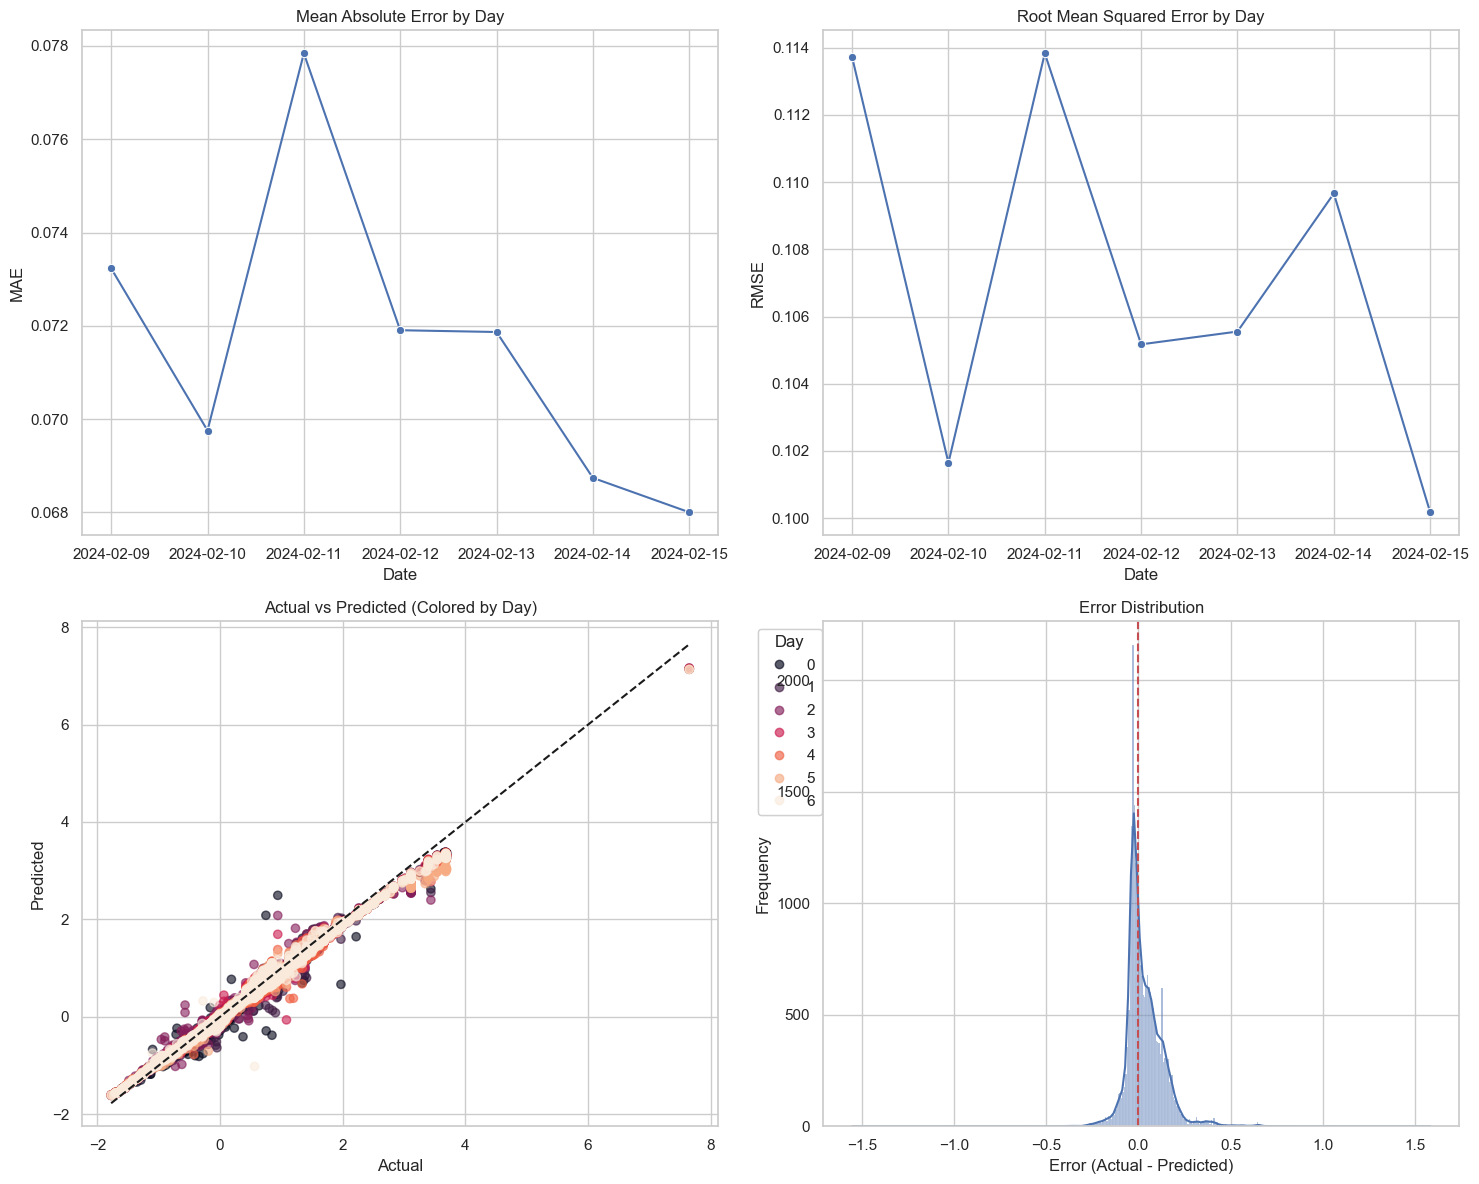

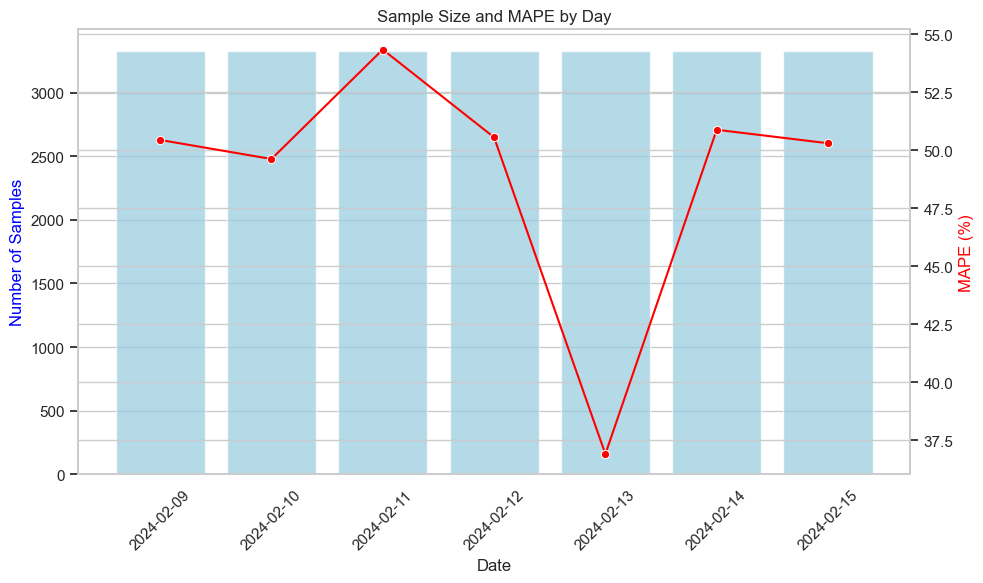


=== RUNNING MODEL WITHOUT 12 FEATURES ===
Processing dataset: train.csv
Features being dropped: ['rolling_mean_7d', 'rolling_max_7d', 'rolling_min_14d', 'rolling_mean_14d', 'rolling_max_14d', 'rolling_min_7d', 'rolling_mean_30d', 'rolling_max_30d', 'rolling_min_30d', 'price_lag_30d', 'price_lag_7d', 'price_lag_1d']
Loading data...
Dropping column: rolling_mean_7d
Dropping column: rolling_max_7d
Dropping column: rolling_min_14d
Dropping column: rolling_mean_14d
Dropping column: rolling_max_14d
Dropping column: rolling_min_7d
Dropping column: rolling_mean_30d
Dropping column: rolling_max_30d
Dropping column: rolling_min_30d
Dropping column: price_lag_30d
Dropping column: price_lag_7d
Dropping column: price_lag_1d
Test set contains 7 unique dates.


Processing days:   0%|          | 0/7 [00:00<?, ?it/s]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing days:  14%|█▍        | 1/7 [00:08<00:51,  8.57s/it]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will 


===== DAY-BY-DAY XGBOOST MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.8618
MAE: 0.6349
R²: 0.2448
MAPE: 326.8911%
Explained Variance: 0.2594
Median Abs Error: 0.4702

=== Daily Performance ===
      date     rmse      mae       mape  n_samples
2024-02-09 0.862892 0.632821 313.247653       3331
2024-02-10 0.865701 0.637994 329.767617       3331
2024-02-11 0.861993 0.633740 322.243531       3331
2024-02-12 0.863597 0.635715 316.549755       3331
2024-02-13 0.862825 0.637470 342.263573       3331
2024-02-14 0.859371 0.634230 337.140029       3331
2024-02-15 0.856510 0.632542 327.025298       3331

=== Performance Statistics ===
MAE:
  Average: 0.6349
  Min: 0.6325 (Day: 2024-02-15)
  Max: 0.6380 (Day: 2024-02-10)

RMSE:
  Average: 0.8618
  Min: 0.8565 (Day: 2024-02-15)
  Max: 0.8657 (Day: 2024-02-10)

MAPE:
  Average: 326.89%
  Min: 313.25% (Day: 2024-02-09)
  Max: 342.26% (Day: 2024-02-13)

=== Top 10 Most Important Features ===
1. distance_weighted_price: 0.385870
2. knn_pri

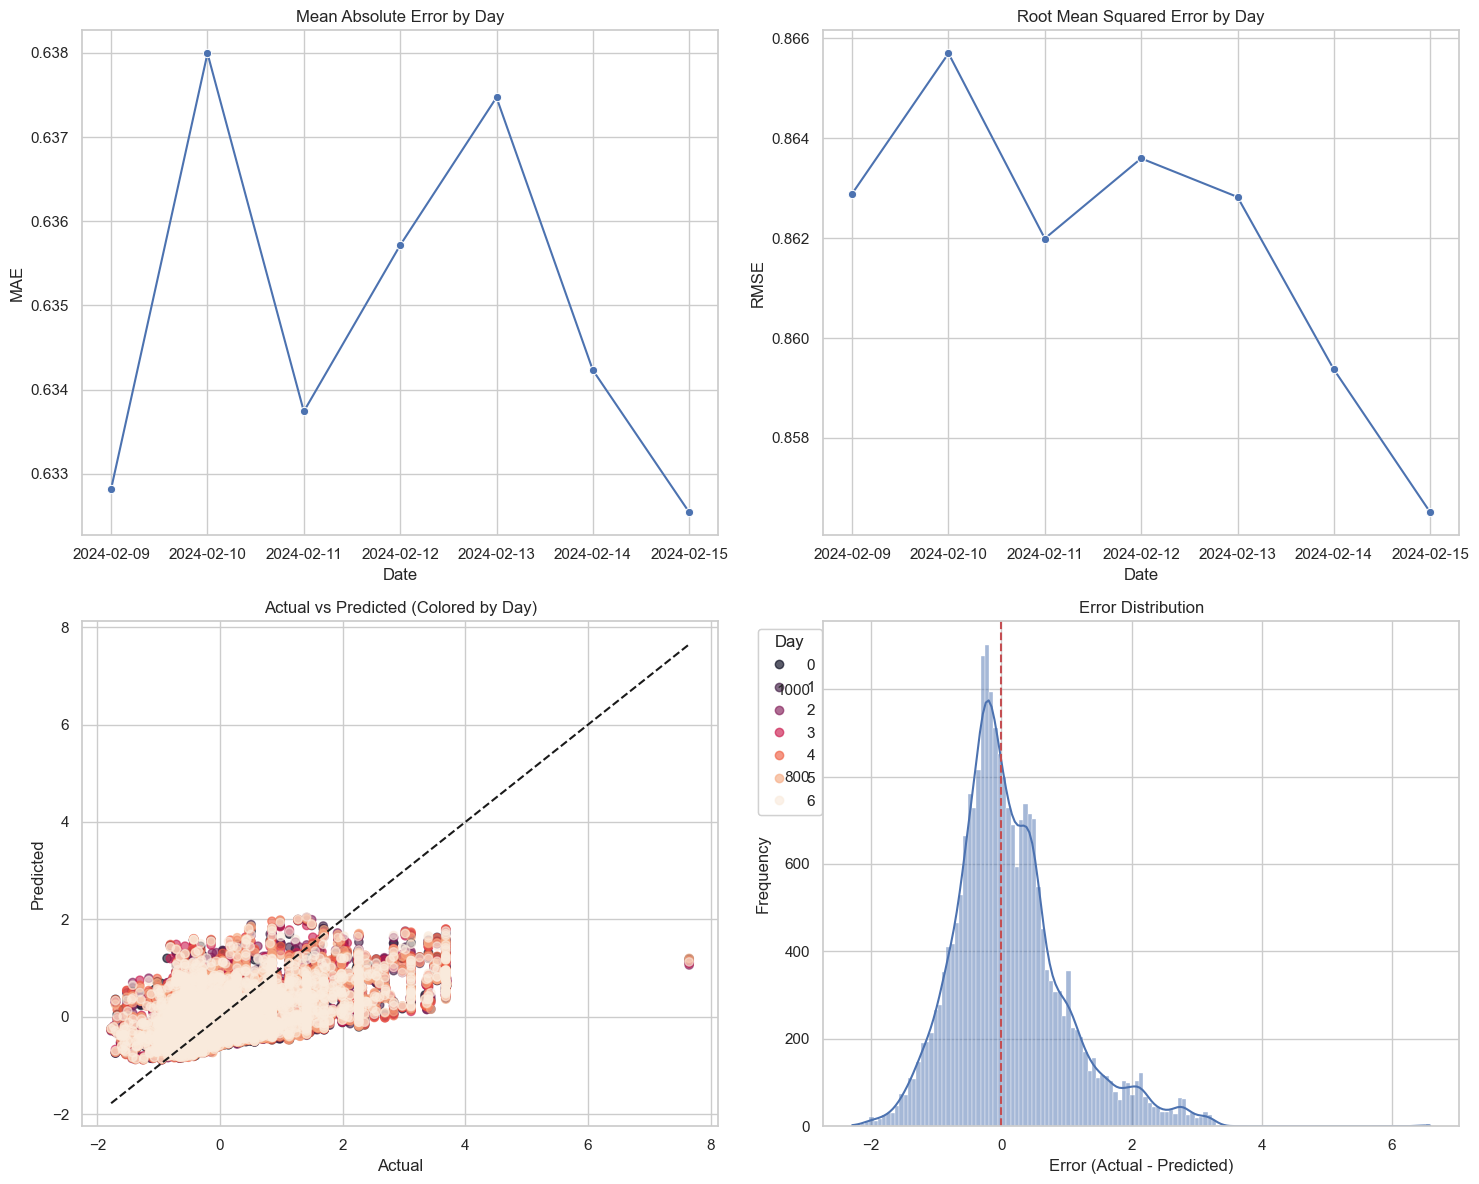

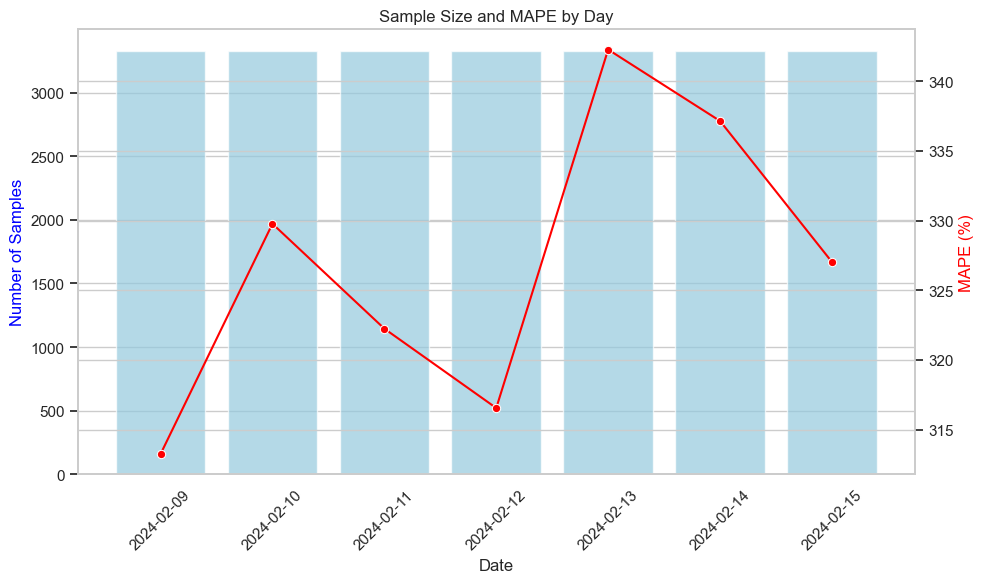


=== PERFORMANCE COMPARISON ===
Features dropped: rolling_mean_7d, rolling_max_7d, rolling_min_14d, rolling_mean_14d, rolling_max_14d, rolling_min_7d, rolling_mean_30d, rolling_max_30d, rolling_min_30d, price_lag_30d, price_lag_7d, price_lag_1d
Metric               Baseline        Ablation        Difference      % Change       
rmse                 0.107228        0.861846        0.754618        703.75         %
mae                  0.071619        0.634930        0.563311        786.54         %
r2                   0.988309        0.244762        0.743547        75.23          %
mape                 49.002728       326.891065      277.888337      567.09         %


========= TESTING top_price_changers_subset - test_feb =========

=== RUNNING BASELINE MODEL FOR top_price_changers_subset, test_feb ===
Processing dataset: train.csv
Features being dropped: []
Loading data...
Test set contains 7 unique dates.


Processing days:   0%|          | 0/7 [00:00<?, ?it/s]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing days:  14%|█▍        | 1/7 [00:52<05:16, 52.70s/it]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will 


===== DAY-BY-DAY XGBOOST MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.0850
MAE: 0.0445
R²: 0.9913
MAPE: 20.9641%
Explained Variance: 0.9913
Median Abs Error: 0.0305

=== Daily Performance ===
      date     rmse      mae      mape  n_samples
2024-02-09 0.092580 0.047035 31.379296       7864
2024-02-10 0.087203 0.043025 14.764396       7864
2024-02-11 0.090560 0.047955 22.589762       7864
2024-02-12 0.084464 0.042861 16.905411       7864
2024-02-13 0.079630 0.041548 13.384646       7864
2024-02-14 0.081345 0.045692 18.796687       7864
2024-02-15 0.077775 0.043288 28.928747       7864

=== Performance Statistics ===
MAE:
  Average: 0.0445
  Min: 0.0415 (Day: 2024-02-13)
  Max: 0.0480 (Day: 2024-02-11)

RMSE:
  Average: 0.0848
  Min: 0.0778 (Day: 2024-02-15)
  Max: 0.0926 (Day: 2024-02-09)

MAPE:
  Average: 20.96%
  Min: 13.38% (Day: 2024-02-13)
  Max: 31.38% (Day: 2024-02-09)

=== Top 10 Most Important Features ===
1. rolling_mean_14d: 0.342824
2. price_lag_1d: 0.270238
3. 

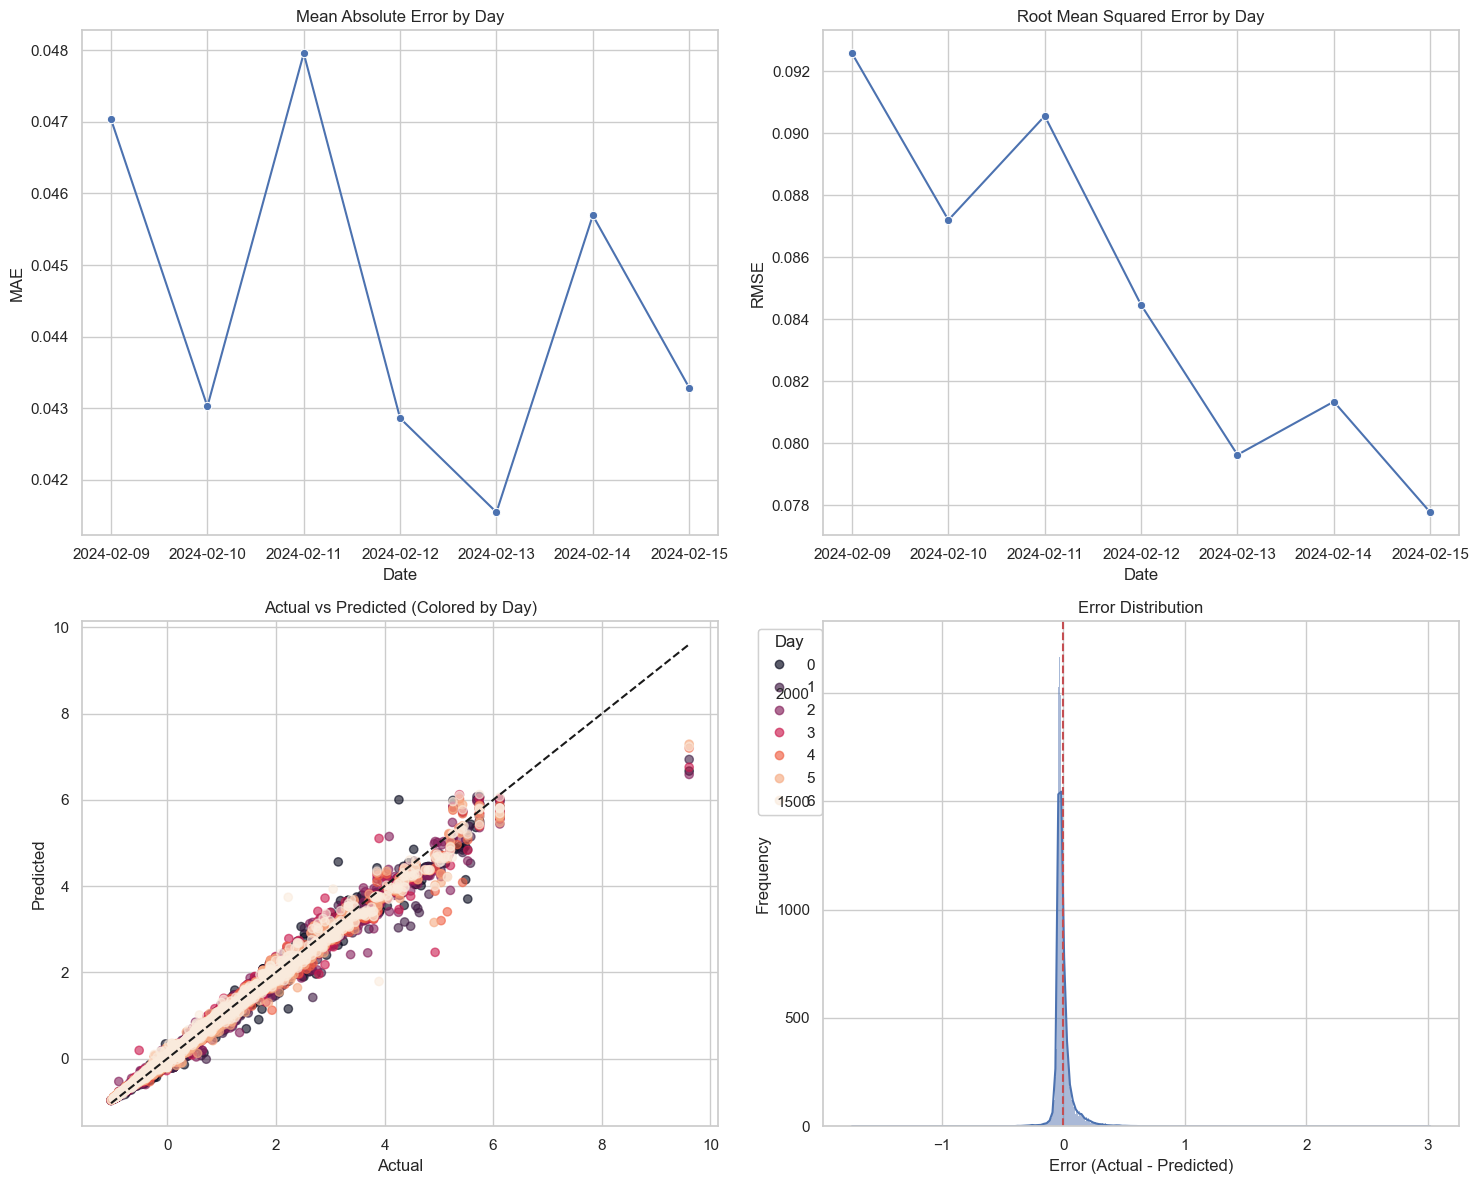

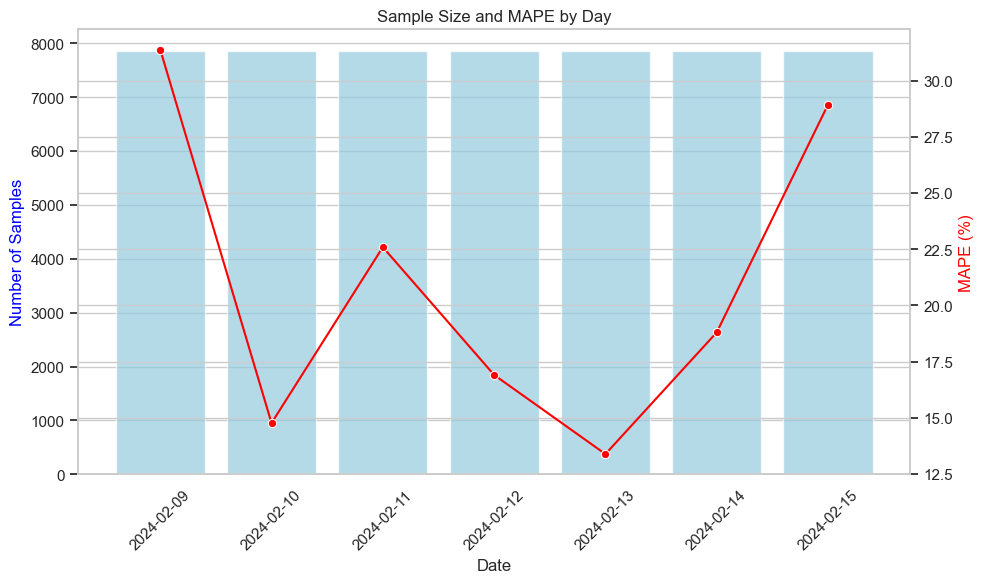


=== RUNNING MODEL WITHOUT 12 FEATURES ===
Processing dataset: train.csv
Features being dropped: ['rolling_mean_7d', 'rolling_max_7d', 'rolling_min_14d', 'rolling_mean_14d', 'rolling_max_14d', 'rolling_min_7d', 'rolling_mean_30d', 'rolling_max_30d', 'rolling_min_30d', 'price_lag_30d', 'price_lag_7d', 'price_lag_1d']
Loading data...
Dropping column: rolling_mean_7d
Dropping column: rolling_max_7d
Dropping column: rolling_min_14d
Dropping column: rolling_mean_14d
Dropping column: rolling_max_14d
Dropping column: rolling_min_7d
Dropping column: rolling_mean_30d
Dropping column: rolling_max_30d
Dropping column: rolling_min_30d
Dropping column: price_lag_30d
Dropping column: price_lag_7d
Dropping column: price_lag_1d
Test set contains 7 unique dates.


Processing days:   0%|          | 0/7 [00:00<?, ?it/s]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing days:  14%|█▍        | 1/7 [00:48<04:48, 48.04s/it]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will 


===== DAY-BY-DAY XGBOOST MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.6197
MAE: 0.4291
R²: 0.5370
MAPE: 262.6027%
Explained Variance: 0.5403
Median Abs Error: 0.2922

=== Daily Performance ===
      date     rmse      mae       mape  n_samples
2024-02-09 0.619408 0.430712 241.648849       7864
2024-02-10 0.622183 0.433618 245.170165       7864
2024-02-11 0.613812 0.423320 276.114558       7864
2024-02-12 0.613754 0.426170 262.240044       7864
2024-02-13 0.626115 0.429621 258.784502       7864
2024-02-14 0.623799 0.431768 254.555164       7864
2024-02-15 0.618620 0.428629 299.705619       7864

=== Performance Statistics ===
MAE:
  Average: 0.4291
  Min: 0.4233 (Day: 2024-02-11)
  Max: 0.4336 (Day: 2024-02-10)

RMSE:
  Average: 0.6197
  Min: 0.6138 (Day: 2024-02-12)
  Max: 0.6261 (Day: 2024-02-13)

MAPE:
  Average: 262.60%
  Min: 241.65% (Day: 2024-02-09)
  Max: 299.71% (Day: 2024-02-15)

=== Top 10 Most Important Features ===
1. distance_weighted_price: 0.382836
2. knn_pri

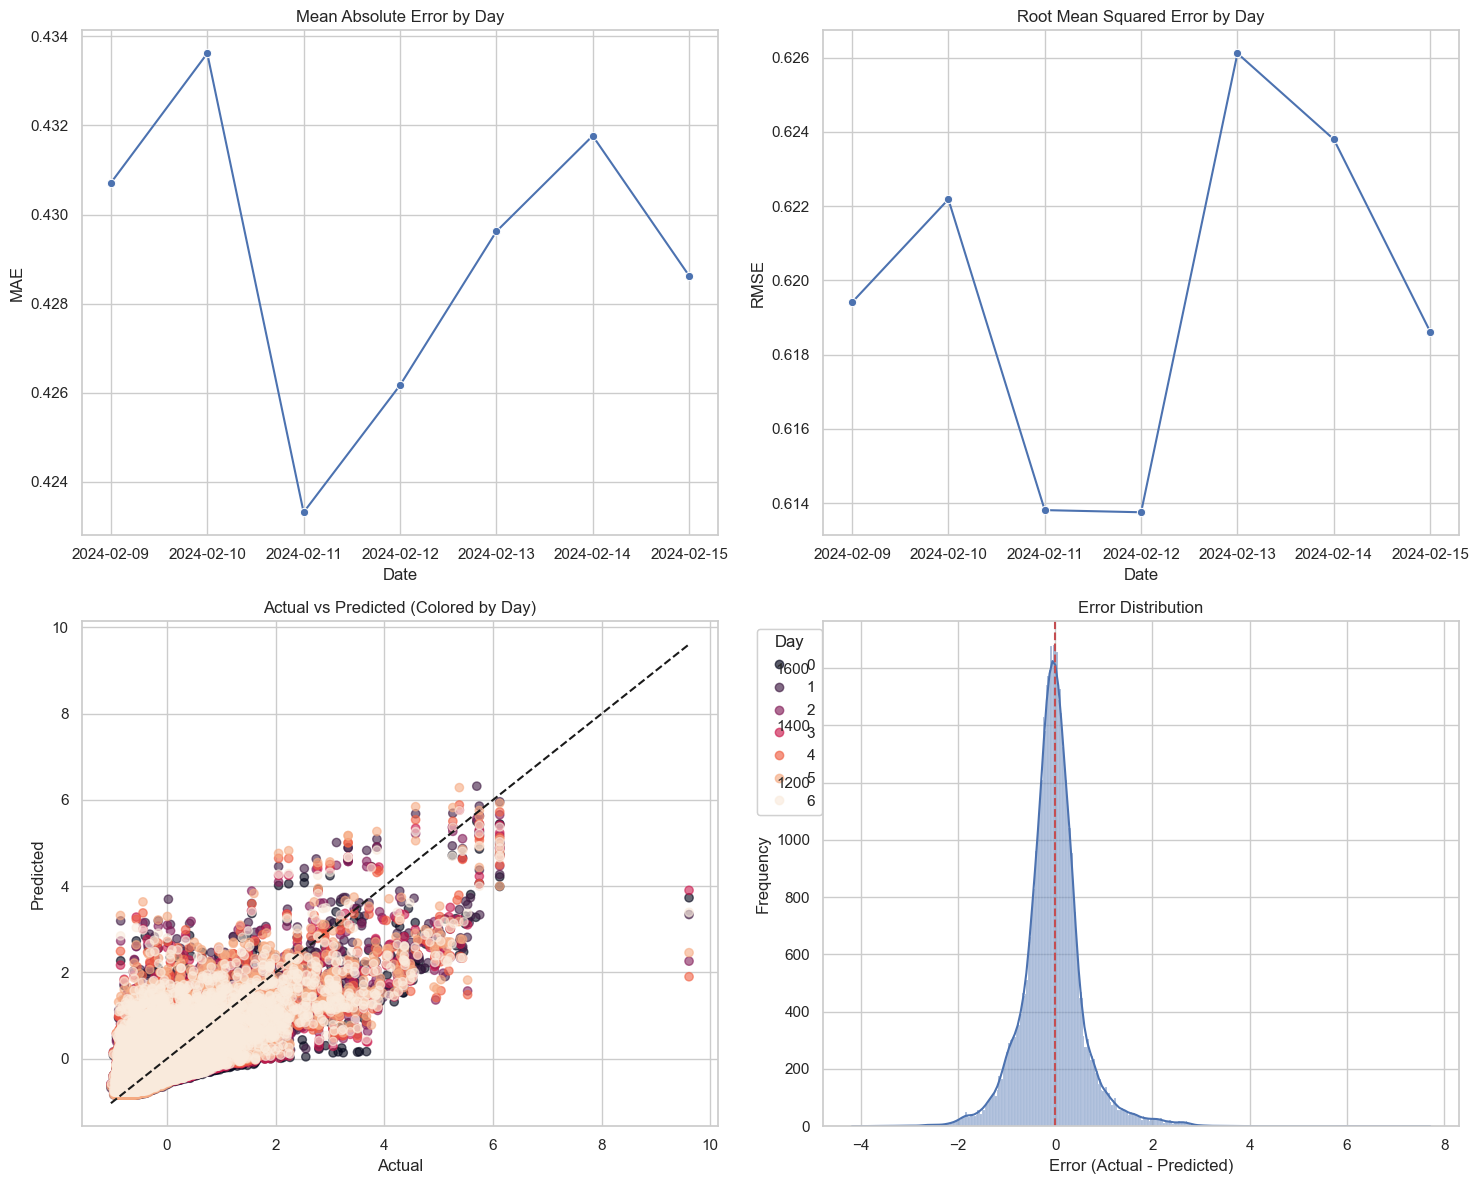

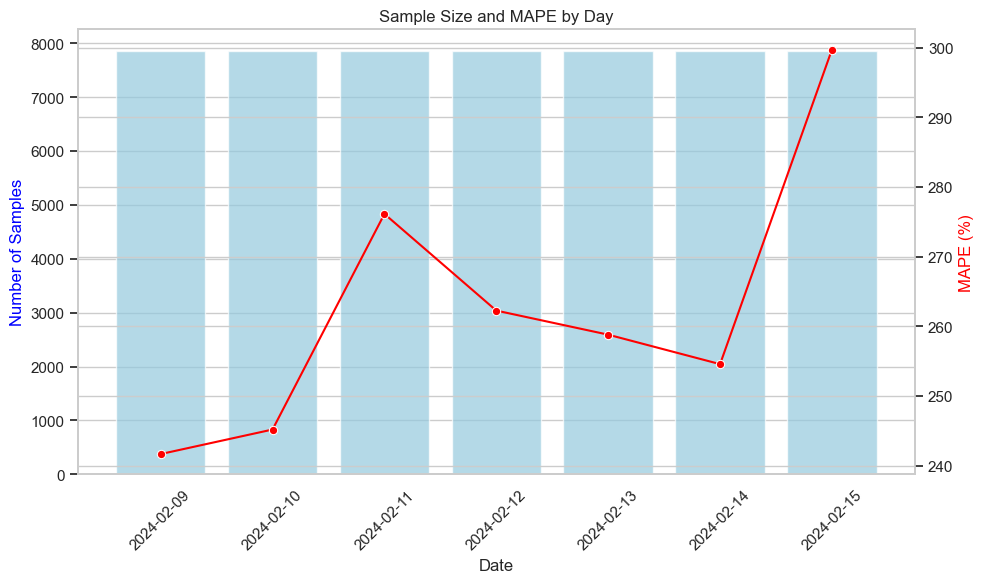


=== PERFORMANCE COMPARISON ===
Features dropped: rolling_mean_7d, rolling_max_7d, rolling_min_14d, rolling_mean_14d, rolling_max_14d, rolling_min_7d, rolling_mean_30d, rolling_max_30d, rolling_min_30d, price_lag_30d, price_lag_7d, price_lag_1d
Metric               Baseline        Ablation        Difference      % Change       
rmse                 0.084952        0.619686        0.534734        629.46         %
mae                  0.044486        0.429120        0.384633        864.61         %
r2                   0.991298        0.536962        0.454336        45.83          %
mape                 20.964135       262.602700      241.638565      1152.63        %


========= TESTING richest_neighborhoods_subset - test_feb =========

=== RUNNING BASELINE MODEL FOR richest_neighborhoods_subset, test_feb ===
Processing dataset: train.csv
Features being dropped: []
Loading data...
Test set contains 7 unique dates.


Processing days:   0%|          | 0/7 [00:00<?, ?it/s]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing days:  14%|█▍        | 1/7 [00:17<01:44, 17.45s/it]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will 


===== DAY-BY-DAY XGBOOST MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.0993
MAE: 0.0526
R²: 0.9908
MAPE: 16.0649%
Explained Variance: 0.9910
Median Abs Error: 0.0302

=== Daily Performance ===
      date     rmse      mae      mape  n_samples
2024-02-09 0.110254 0.056101 14.080765       3762
2024-02-10 0.099431 0.052726 16.085163       3762
2024-02-11 0.101437 0.055535 19.999534       3762
2024-02-12 0.101644 0.054782 14.988794       3762
2024-02-13 0.094167 0.050022 15.932785       3762
2024-02-14 0.098044 0.050783 14.867363       3762
2024-02-15 0.088870 0.048176 16.499832       3762

=== Performance Statistics ===
MAE:
  Average: 0.0526
  Min: 0.0482 (Day: 2024-02-15)
  Max: 0.0561 (Day: 2024-02-09)

RMSE:
  Average: 0.0991
  Min: 0.0889 (Day: 2024-02-15)
  Max: 0.1103 (Day: 2024-02-09)

MAPE:
  Average: 16.06%
  Min: 14.08% (Day: 2024-02-09)
  Max: 20.00% (Day: 2024-02-11)

=== Top 10 Most Important Features ===
1. rolling_mean_14d: 0.371600
2. price_lag_1d: 0.310946
3. 

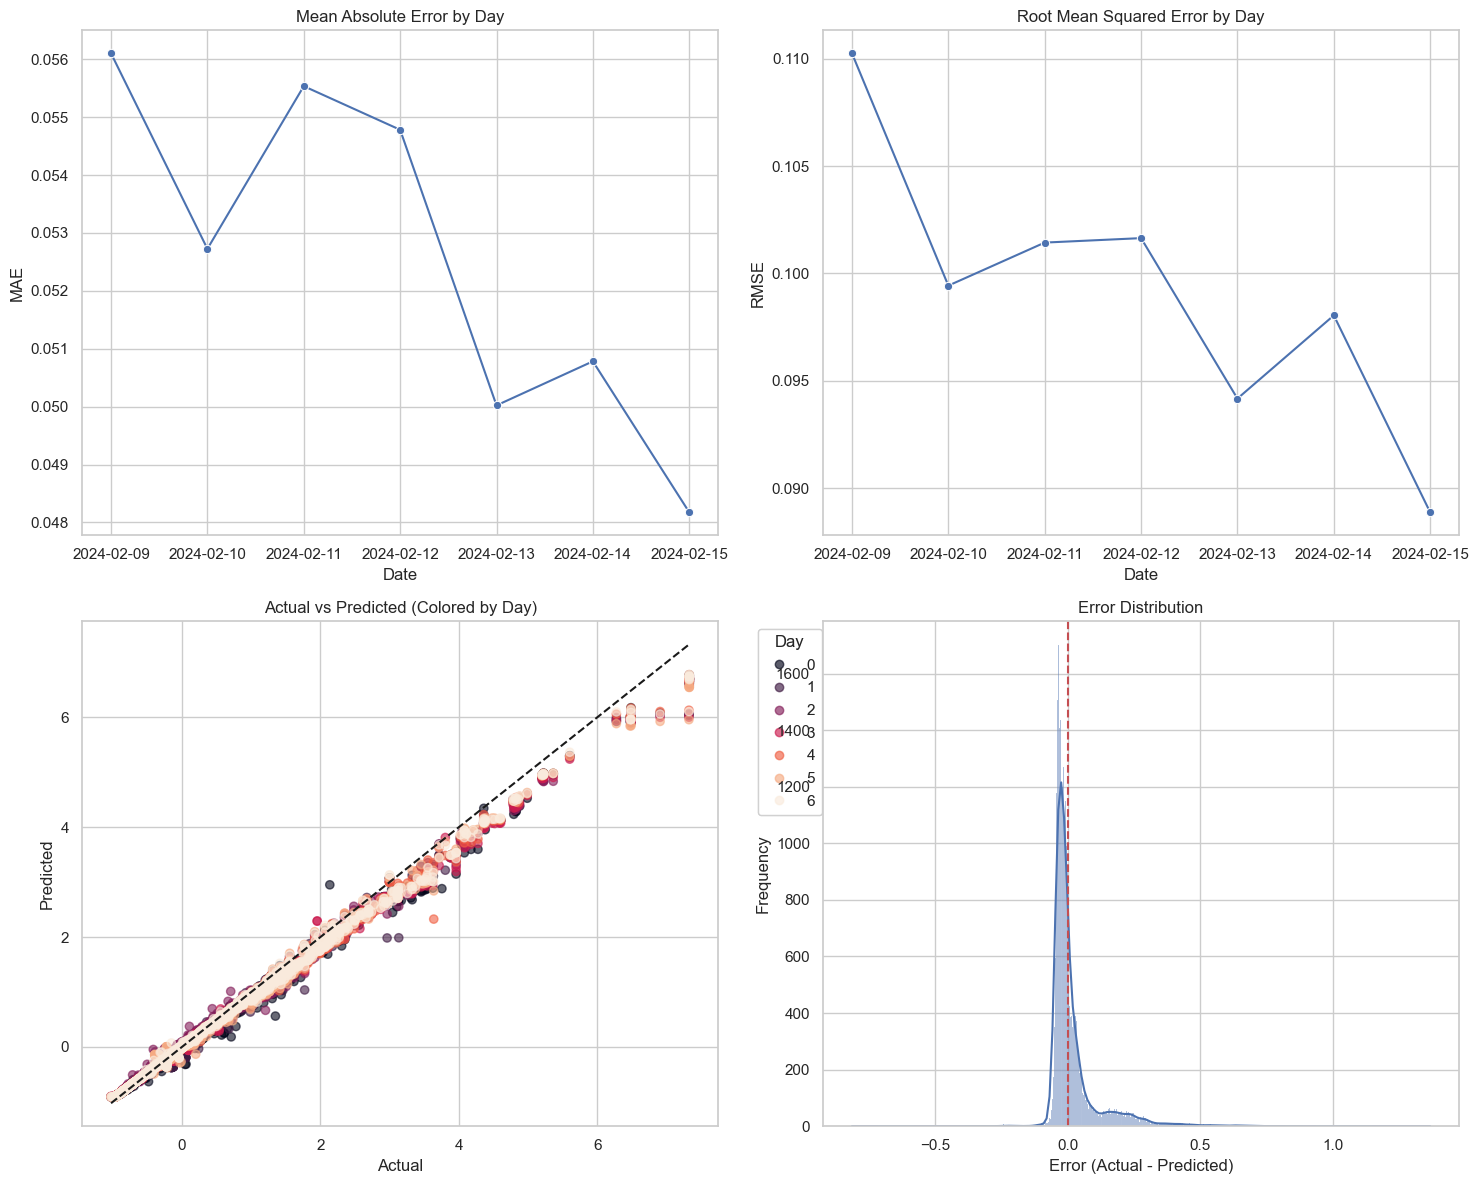

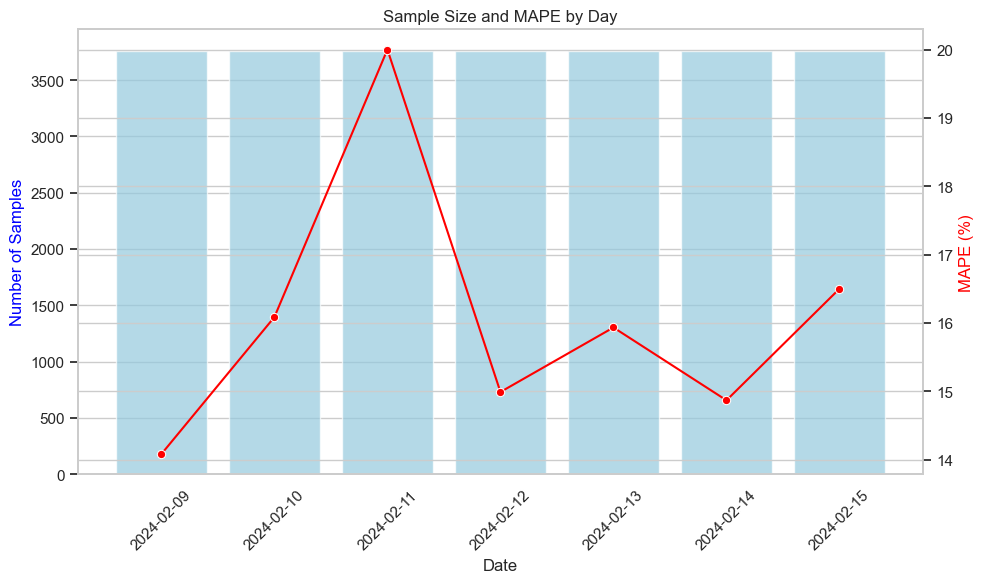


=== RUNNING MODEL WITHOUT 12 FEATURES ===
Processing dataset: train.csv
Features being dropped: ['rolling_mean_7d', 'rolling_max_7d', 'rolling_min_14d', 'rolling_mean_14d', 'rolling_max_14d', 'rolling_min_7d', 'rolling_mean_30d', 'rolling_max_30d', 'rolling_min_30d', 'price_lag_30d', 'price_lag_7d', 'price_lag_1d']
Loading data...
Dropping column: rolling_mean_7d
Dropping column: rolling_max_7d
Dropping column: rolling_min_14d
Dropping column: rolling_mean_14d
Dropping column: rolling_max_14d
Dropping column: rolling_min_7d
Dropping column: rolling_mean_30d
Dropping column: rolling_max_30d
Dropping column: rolling_min_30d
Dropping column: price_lag_30d
Dropping column: price_lag_7d
Dropping column: price_lag_1d
Test set contains 7 unique dates.


Processing days:   0%|          | 0/7 [00:00<?, ?it/s]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing days:  14%|█▍        | 1/7 [00:11<01:10, 11.67s/it]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will 


===== DAY-BY-DAY XGBOOST MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.9316
MAE: 0.6169
R²: 0.1879
MAPE: 358.7820%
Explained Variance: 0.1881
Median Abs Error: 0.4209

=== Daily Performance ===
      date     rmse      mae       mape  n_samples
2024-02-09 0.927238 0.615567 316.825822       3762
2024-02-10 0.937422 0.619611 312.212919       3762
2024-02-11 0.931467 0.620370 390.731917       3762
2024-02-12 0.935260 0.617305 374.318699       3762
2024-02-13 0.941203 0.618132 366.401856       3762
2024-02-14 0.920854 0.610933 365.613403       3762
2024-02-15 0.927285 0.616510 385.369491       3762

=== Performance Statistics ===
MAE:
  Average: 0.6169
  Min: 0.6109 (Day: 2024-02-14)
  Max: 0.6204 (Day: 2024-02-11)

RMSE:
  Average: 0.9315
  Min: 0.9209 (Day: 2024-02-14)
  Max: 0.9412 (Day: 2024-02-13)

MAPE:
  Average: 358.78%
  Min: 312.21% (Day: 2024-02-10)
  Max: 390.73% (Day: 2024-02-11)

=== Top 10 Most Important Features ===
1. distance_weighted_price: 0.421695
2. knn_pri

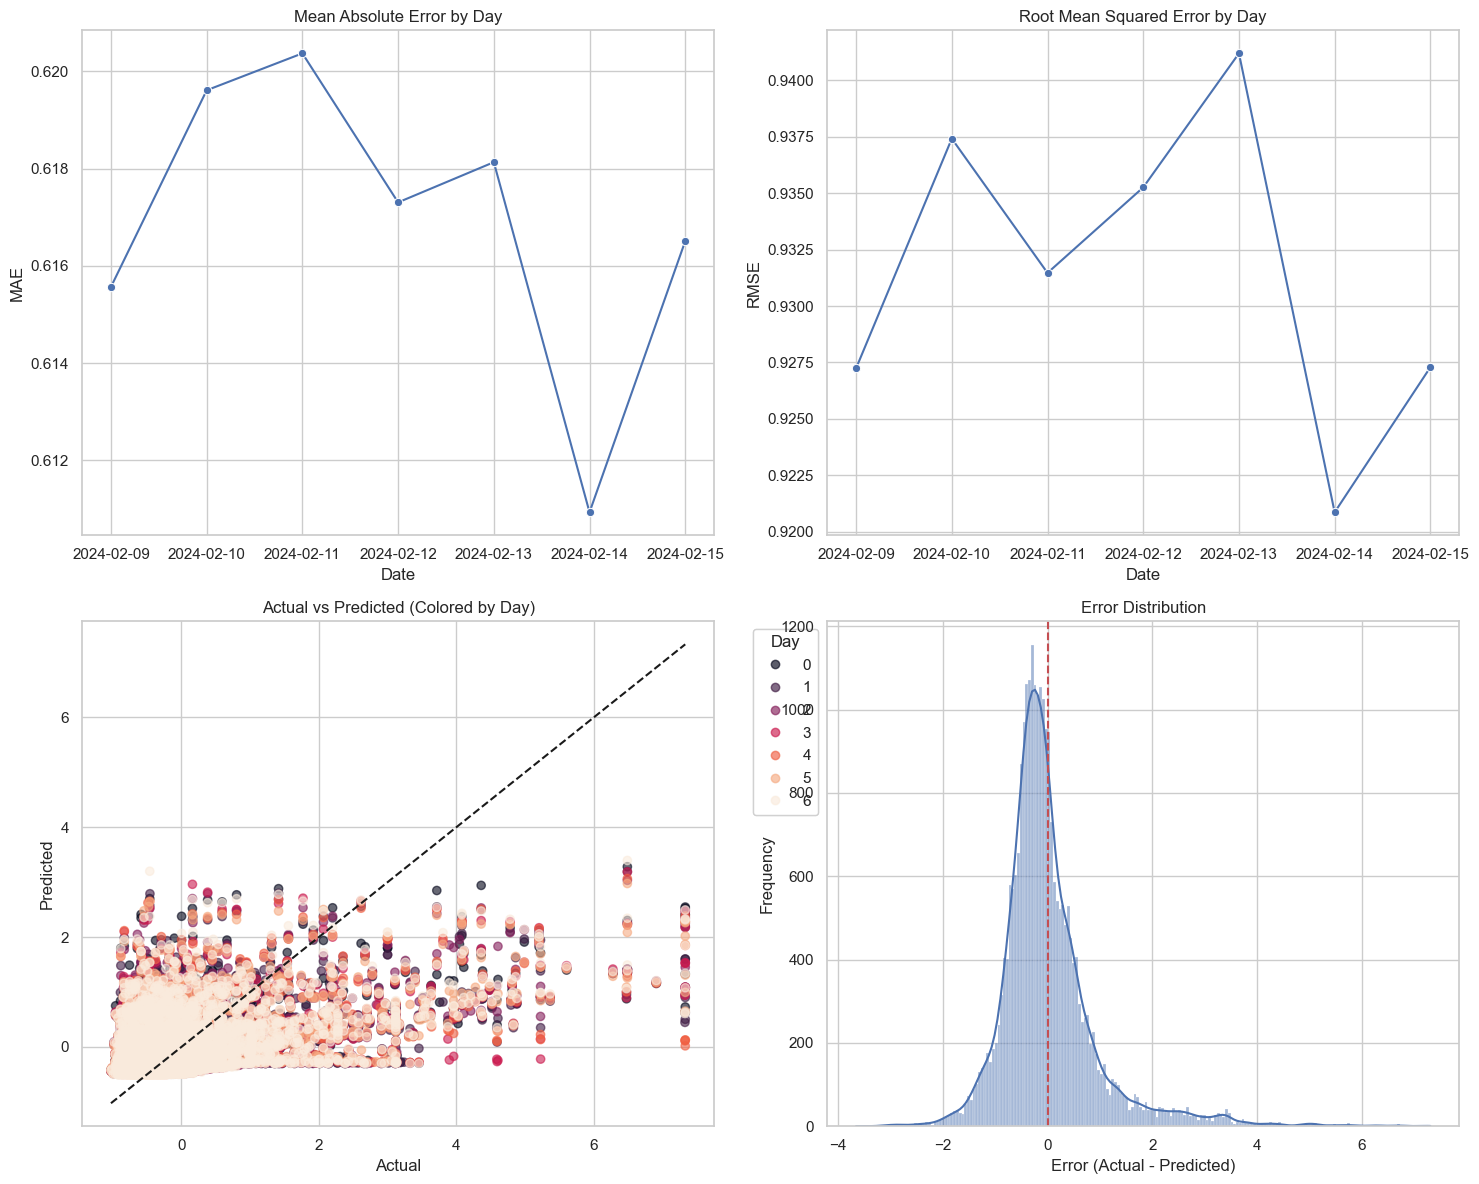

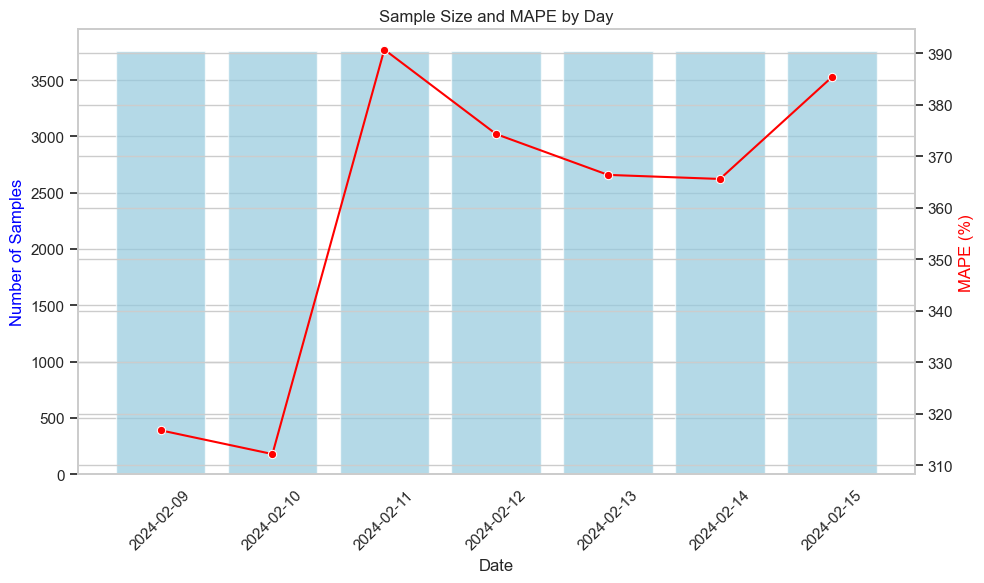


=== PERFORMANCE COMPARISON ===
Features dropped: rolling_mean_7d, rolling_max_7d, rolling_min_14d, rolling_mean_14d, rolling_max_14d, rolling_min_7d, rolling_mean_30d, rolling_max_30d, rolling_min_30d, price_lag_30d, price_lag_7d, price_lag_1d
Metric               Baseline        Ablation        Difference      % Change       
rmse                 0.099313        0.931555        0.832242        838.00         %
mae                  0.052589        0.616918        0.564329        1073.09        %
r2                   0.990770        0.187870        0.802900        81.04          %
mape                 16.064891       358.782015      342.717124      2133.33        %


In [3]:
# Example usage
if __name__ == "__main__":
    # # Simple example with defaults
    # results = run_ablation_experiment(
    #     subset_name="poorest_neighborhoods_subset", 
    #     test_period="test_feb"
    # )
    
    # Example of running multiple experiments in a loop
    subsets = ["top_expensive_listings_subset", "top_price_changers_subset", "richest_neighborhoods_subset"]
    test_periods = ["test_feb"]
    
    all_results = {}
    for subset in subsets:
        all_results[subset] = {}
        for period in test_periods:
            print(f"\n\n========= TESTING {subset} - {period} =========")
            all_results[subset][period] = run_ablation_experiment(subset, period)